# Introduction, DataLoaders

The small histopathology dataset consists of 25 patients data that are taken from the large set of histopathology data. Its purpose is for model prototyping before deploying our training set on a larger model.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the Python files
FOLDERNAME = '/Histopathology'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


First, we want to load our dataset and check for its content. We will be writing a custom Pytorch Dataset Loader for this.

Tutorial Source: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
import os
import torch
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

In [13]:
class HistologyDataset(Dataset):
  '''Pytorch Dataset subclass that will load the histology data'''
  def __init__(self, patches, transform = None):
    '''
    Input:
      root_dir (string): Directory where all images are hosted
      patches (list): List of all images patches to be included in the dataset
      transform (callable, optional): Optional transform to be applied on a sample.
    Output:
      None
    '''
    self.patches = patches
    self.transform = transform

  def __len__(self):
    '''
    Output: 
      The number of patches
    '''
    return len(self.patches)

  def __getitem__(self, idx):
    '''
    Read images such that dataset[i] can be used to get the i_th sample
    Return:
      sample: dict consists of image and label
    '''
    if torch.is_tensor(idx):
      idx = idx.tolist()
    patch_name = self.patches[idx]
    X = io.imread(self.patches[idx])
    y = self.getlabel(patch_name)
    if self.transform:
      X = self.transform(X)
    return X, y

  def getlabel(self, filepath):
    '''
    Return the label of the image from the patches name
    '''
    filename = os.path.basename(filepath)
    patch_name = filename.split(sep = ".")[0]
    class_label = patch_name.split(sep = "_")[4]
    label = int(class_label[-1])
    return label


In [11]:
root_dir = "/content/drive/My Drive/Data/histopathology_small.zip"
seed = 42

if not os.path.exists("/content/histopathology_small"):
  !mkdir histopathology_small
!unzip '/content/drive/My Drive/Data/histopathology_small.zip' -d histopathology_small

Streaming output truncated to the last 5000 lines.
  inflating: histopathology_small/histopathology_small/9126/1/9126_idx5_x1651_y1351_class1.png  
  inflating: histopathology_small/histopathology_small/9126/1/9126_idx5_x1651_y1401_class1.png  
  inflating: histopathology_small/histopathology_small/9126/1/9126_idx5_x1651_y1451_class1.png  
  inflating: histopathology_small/histopathology_small/9126/1/9126_idx5_x1651_y951_class1.png  
  inflating: histopathology_small/histopathology_small/9126/1/9126_idx5_x1701_y1001_class1.png  
  inflating: histopathology_small/histopathology_small/9126/1/9126_idx5_x1701_y1051_class1.png  
  inflating: histopathology_small/histopathology_small/9126/1/9126_idx5_x1701_y1101_class1.png  
  inflating: histopathology_small/histopathology_small/9126/1/9126_idx5_x1701_y1151_class1.png  
  inflating: histopathology_small/histopathology_small/9126/1/9126_idx5_x1701_y1201_class1.png  
  inflating: histopathology_small/histopathology_small/9126/1/9126_idx5_x1701

0 (50, 50, 3)
1 (50, 50, 3)
2 (50, 50, 3)
3 (50, 50, 3)
4 (50, 50, 3)
5 (50, 50, 3)
6 (50, 50, 3)
7 (50, 50, 3)
8 (50, 50, 3)
9 (50, 50, 3)


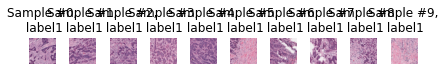

In [17]:
root_dir = "/content/histopathology_small/histopathology_small"
seed = 42

def assert_patches(fname):
  name = os.path.basename(fname)
  patch_name = name.split(sep = ".")[0]
  f = patch_name.split(sep = "_")
  if len(f) != 5: return False
  if not f[4][-1].isdigit(): return False
  return True

patches = glob.glob(root_dir + "/*/*/*.png")
patches = [p for p in patches if assert_patches(p)]
histology_dataset = HistologyDataset(patches = patches)
fig = plt.figure()
for i in range(len(histology_dataset)):
  x, y = histology_dataset[i]
  print(i, x.shape)
  ax = plt.subplot(1, 10, i + 1)
  plt.tight_layout()
  ax.set_title('Sample #{},\n label{}'.format(i, y))
  ax.axis('off')
  plt.imshow(x)
  if i == 9:
    plt.show()
    break


This is looking good. Now, in order to load this dataset into Pytorch, we have to transform it into Pytorch tensors. We write a class call ToTensor.

In [18]:
from torchvision import transforms
import skimage

class Image_Resize(object):
  def __init__(self, output_size):
    self.output_size = output_size
  def __call__(self, x):
    return skimage.transform.resize(x, self.output_size)
    
class ToTensor(object):
  def __call__(self, x):
    x = x.transpose((2, 0, 1))
    return x

Now, let's try to call this function using the transfrom we created.

In [19]:
from torchvision import transforms, utils

transformed_dataset = HistologyDataset(patches = patches, transform = transforms.Compose([Image_Resize((50, 50)), ToTensor()]))
for i in range(1, 5):
  sample = transformed_dataset[i]
  x, y = sample
  print(x.shape, y)

(3, 50, 50) 1
(3, 50, 50) 1
(3, 50, 50) 1
(3, 50, 50) 1


However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

torch.utils.data.DataLoader is an iterator which provides all these features.

Batch no  0 torch.Size([8, 3, 50, 50]) torch.Size([8])
Batch no  1 torch.Size([8, 3, 50, 50]) torch.Size([8])
Batch no  2 torch.Size([8, 3, 50, 50]) torch.Size([8])
Batch no  3 torch.Size([8, 3, 50, 50]) torch.Size([8])
Batch no  4 torch.Size([8, 3, 50, 50]) torch.Size([8])


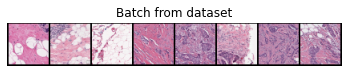

In [20]:
dataloader = DataLoader(transformed_dataset, batch_size=8, shuffle=True, num_workers=0)
def show_batch(sample_batch):
  '''Show images within a batch of samples'''
  grid = utils.make_grid(sample_batch, nrows = 2)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.title("Batch from dataset")

for i_batch, (sample_batch, label) in enumerate(dataloader):
  print("Batch no ", i_batch, sample_batch.size(), label.size())
  if i_batch == 4:
    plt.figure()
    show_batch(sample_batch)
    plt.axis('off')
    plt.ioff()
    plt.show()
    break

# Train and Test Data

Now, let's split the data into a train set and a validation set. No test set neccessary yet. Remember that this is just a toy dataset that we prototype our code on. Once we are done prototyping this we can load a test set using a different set of patients.

In [22]:
root_dir = "/content/histopathology_small/histopathology_small"
seed = 42

patients = glob.glob(root_dir + "/*")
#We want to achieve the same replication, so set a seed
np.random.seed(seed)
np.random.shuffle(patients)

train_val_split = 0.8
# It is important to split the data by patients, as this ensure no bias.
train_patients = patients[:int(len(patients) * train_val_split)]
val_patients = patients[int(len(patients) * train_val_split):]

train_patches = []
for train_p in train_patients:
    patch = glob.glob(train_p + "/*/*.png")
    train_patches += [p for p in patch if assert_patches(p)]
val_patches = []
for val_p in val_patients:
    patch = glob.glob(val_p + "/*/*.png")
    val_patches += [p for p in patch if assert_patches(p)]

def get_label(filepath):
  '''
  Return the label of the image from the patches name
  '''
  filename = os.path.basename(filepath)
  patch_name = filename.split(sep = ".")[0]
  class_label = patch_name.split(sep = "_")[4]
  label = int(class_label[-1])

train_labels = [get_label(i) for i in train_patches]
val_labels = [get_label(i) for i in val_patches]

print("There are {} patients in the train set and {} patients in the validation set".format(len(train_patients), len(val_patients)))
print("There are {} patches in the train set and {} patches in the validation set".format(len(train_patches), len(val_patches)))

There are 20 patients in the train set and 5 patients in the validation set
There are 18893 patches in the train set and 5631 patches in the validation set


# Build a Model

Let's start with a simple network.

In [24]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

USE_GPU = True
dtype = torch.float32 # we will be using float throughout this

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [26]:
class Flatten(nn.Module):
    def forward(self, x):
        N = x.shape[0] # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

model = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = 5, stride = 1, padding = 2),
    nn.ReLU(),
    nn.BatchNorm2d(num_features = 128),

    nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d(num_features = 64),

    nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d(num_features = 32),

    nn.Conv2d(in_channels = 32, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d(num_features = 8),

    Flatten(),

    nn.Linear(8 * 50 * 50, 50),
    nn.ReLU(),
    nn.Dropout(p = 0.15),
    
    nn.Linear(50, 1),
    nn.Dropout(p = 0.15)
).to(device)

We want to check the accuracy of our dataset, so we will write a function call check_accuracy

In [36]:
def check_accuracy(loader, model, threshold = 0.5):
  print('Checking accuracy on validation set')
  num_correct = 0
  num_samples = 0
  model.eval()
  with torch.no_grad():
    for t, (x, y) in enumerate(loader):
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=torch.uint8).unsqueeze(1)
      scores = model(x)
      sigmoid = nn.Sigmoid()
      preds = sigmoid(scores)
      preds[preds < threshold] = 0
      preds[preds > threshold] = 1
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

Now we can start training 

In [29]:
model = model.to(device=device)  # move the model parameters to CPU/GPU
epochs = 25

transformed_train = HistologyDataset(patches = train_patches, transform = transforms.Compose([Image_Resize((50, 50)), ToTensor()]))
loader_train = DataLoader(transformed_train, batch_size=64, shuffle=True, num_workers=0)

transformed_val = HistologyDataset(patches = val_patches, transform = transforms.Compose([Image_Resize((50, 50)), ToTensor()]))
loader_val = DataLoader(transformed_val, batch_size=64, shuffle=True, num_workers=0)

optimizer = optim.SGD(model.parameters(), lr = 3e-3, momentum = 0.9, nesterov=True)

criterion = nn.BCEWithLogitsLoss()

for e in range(epochs):
    for t, (x, y) in enumerate(loader_train):

        model.train()  # put model to training mode
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long).unsqueeze(1)

        scores = model(x)
        y = y.type_as(scores)
        loss = criterion(scores, y)

        # Zero out all of the gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()

        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward()

        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        optimizer.step()
                
        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy(loader_val, model)
            print()
        

Iteration 0, loss = 0.5328
Checking accuracy on validation set
Got 349 / 384 correct (90.89)

Iteration 100, loss = 0.4622
Checking accuracy on validation set
Got 282 / 384 correct (73.44)

Iteration 200, loss = 0.2761
Checking accuracy on validation set
Got 311 / 384 correct (80.99)

Iteration 0, loss = 0.4276
Checking accuracy on validation set
Got 321 / 384 correct (83.59)

Iteration 100, loss = 0.2514
Checking accuracy on validation set
Got 319 / 384 correct (83.07)

Iteration 200, loss = 0.3571
Checking accuracy on validation set
Got 249 / 384 correct (64.84)

Iteration 0, loss = 0.2809
Checking accuracy on validation set
Got 328 / 384 correct (85.42)

Iteration 100, loss = 0.2783
Checking accuracy on validation set
Got 332 / 384 correct (86.46)

Iteration 200, loss = 0.2079
Checking accuracy on validation set
Got 275 / 384 correct (71.61)

Iteration 0, loss = 0.3219
Checking accuracy on validation set
Got 336 / 384 correct (87.50)

Iteration 100, loss = 0.2465
Checking accuracy o

In [37]:
check_accuracy(loader_val, model)

Checking accuracy on validation set
Got 4883 / 5631 correct (86.72)


We want to save our model

In [34]:
save_path = "/content/drive/My Drive/model.pt"
torch.save(model.state_dict(), save_path)

In [59]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

scores = torch.empty(0,1).to(device=device, dtype=dtype) 
y_val = torch.empty(0,1).to(device=device, dtype=dtype) 
model.eval()
threshold = 0.5
with torch.no_grad():
  for t, (x, y) in enumerate(loader_val):
    x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
    y = y.to(device=device, dtype=torch.uint8).unsqueeze(1)
    score = model(x)
    sigmoid = nn.Sigmoid()
    scores = torch.cat((scores, sigmoid(score)))
    y_val = torch.cat((y_val, y))

preds = torch.clone(scores)
preds[preds < threshold] = 0
preds[preds > threshold] = 1

Threshold = 0.5, Accuracy = 0.87


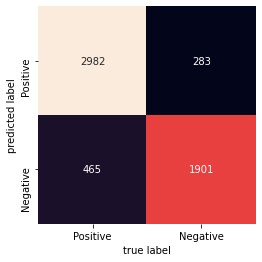

In [75]:
preds = torch.clone(scores)
threshold = 0.50
preds[preds < threshold] = 0
preds[preds > threshold] = 1

y_val_cpu = y_val.cpu().numpy()
preds_cpu = preds.cpu().numpy()

print("Threshold = {}, Accuracy = {:.2f}".format(threshold ,np.sum(y_val_cpu == preds_cpu)/len(preds_cpu)))

mat = confusion_matrix(y_val_cpu, preds_cpu)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [76]:
from sklearn.metrics import f1_score
print(f1_score(y_val_cpu, preds_cpu))

0.8356043956043956


In [77]:
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(y_val_cpu, preds_cpu))

0.8677606662267237
